In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
#!pip install dgl -f https://data.dgl.ai/wheels/repo.html
!pip install dgl-cu111 dglgo -f https://data.dgl.ai/wheels/repo.html
!pip install dive-into-graphs
!pip install pydig
!pip install pgmpy
!pip install 'git+https://github.com/lanpa/tensorboardX'

1.12.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lanpa/tensorboardX to /tmp/pip-req-build-3nkod2he
  Running command git clone -q https://github.com/lanpa/tensorboardX /tmp/pip-req-build-3nkod2he
  Created wheel for tensorboardX: filename=tensorboardX-2.5.1-py2.py3-none-any.whl size=125366 sha256=23f30648fc93c566526ea6f1c804b213d57d783be09b6b3e595ebb68a36b45b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-1z9u0cvy/wheels/b7/a3/60/1fb0fb70622c281e7b4

In [52]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from termcolor import colored
from torch._C import dtype

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear
from sklearn.model_selection import train_test_split
import numpy as np
import pgmpy
import sklearn
import tensorboardX
import pandas
import scipy
import networkx
import random

from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from operator import add
import tensorflow as tf

#. DGL
import dgl
import dgl.function as fn
from dgl.data import GINDataset
from dgl.dataloading import GraphDataLoader
from dgl.nn import AvgPooling
from torch_geometric.nn import global_mean_pool
from torch_geometric.datasets import TUDataset



#. DIG
from dig.xgraph.dataset import SynGraphDataset
from dig.xgraph.utils.compatibility import compatible_state_dict
from dig.xgraph.method.subgraphx import PlotUtils
from dig.xgraph.method.subgraphx import MCTS
from torch_geometric.utils import to_networkx
from dig.xgraph.models import GCN_2l

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Explainability_name = 'PGMExplainer'
Task_name = 'Node Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [5]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [6]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
#dataset = SynGraphDataset('./datasets', 'BA_shapes')

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
#print(np.shape(dataset))
print(data)
print(colored('===========================================================================================================', 'red'))


# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Number of val nodes: {data.val_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Number of test nodes: 1000
Number of val nodes: 500
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [7]:
print(len(data.x[0]))
print(len(data.x))
print(len(data.y))
print(data.y[0])
print(f'MAX: {max(data.y)}')
print(f'MIN: {min(data.y)}')
print(data.x[0])
print(len(data.edge_index[0]))
print("-------------------------------------")


1433
2708
2708
tensor(3)
MAX: 6
MIN: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])
10556
-------------------------------------


In [8]:
def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool, device=index.device)
    mask[index] = 1
    return mask

In [9]:
def split_dataset(dataset):
    indices = []
    train_percent = 0.7

    num_classes = dataset.num_classes
    
    for i in range(num_classes):
        index = (dataset.data.y == i).nonzero().view(-1)
        index = index[torch.randperm(index.size(0))]
        indices.append(index)

    train_index = torch.cat([i[:int(len(i) * train_percent)] for i in indices], dim=0)
    rest_index = torch.cat([i[int(len(i) * train_percent):] for i in indices], dim=0)

    #print(len(train_index.tolist()), len(rest_index.tolist()))
    print(len(train_index))
    rest_index = rest_index[torch.randperm(rest_index.size(0))]

    dataset.data.train_mask = index_to_mask(train_index, size=dataset.data.num_nodes)
    dataset.data.test_mask = index_to_mask(rest_index, size=dataset.data.num_nodes)

    dataset.data, dataset.slices = dataset.collate([dataset.data])

    return dataset
    #return train_index, rest_index

In [10]:
One_Graph_Dataset = split_dataset(dataset)
dataset_PGMExplainer = One_Graph_Dataset[0]
print(dataset_PGMExplainer)

1891
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


# **GCN MODEL**

In [11]:
class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
      super().__init__()
      torch.manual_seed(1234567)
      self.conv1 = GCNConv(dataset.num_features, hidden_channels)
      self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
      self.linear1 = Linear(7,7)

  def forward(self, x, edge_index):
      x = self.conv1(x, edge_index)
      x = F.relu(x)

      x = self.conv2(x, edge_index)
      x = F.relu(x)

      x = self.linear1(x)
      x = F.relu(x)

      x = F.dropout(x, p=0.5, training=self.training)
      return x

GCN_Model_mine = GCN(hidden_channels=7)
print(GCN_Model_mine)

GCN(
  (conv1): GCNConv(1433, 7)
  (conv2): GCNConv(7, 7)
  (linear1): Linear(in_features=7, out_features=7, bias=True)
)


GCN_2l(
  (conv1): GCNConv(1433, 100)
  (convs): ModuleList(
    (0): GCNConv(100, 100)
  )
  (relu1): ReLU()
  (relus): ModuleList(
    (0): ReLU()
  )
  (readout): IdenticalPool()
  (ffn): Sequential(
    (0): Linear(in_features=100, out_features=7, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


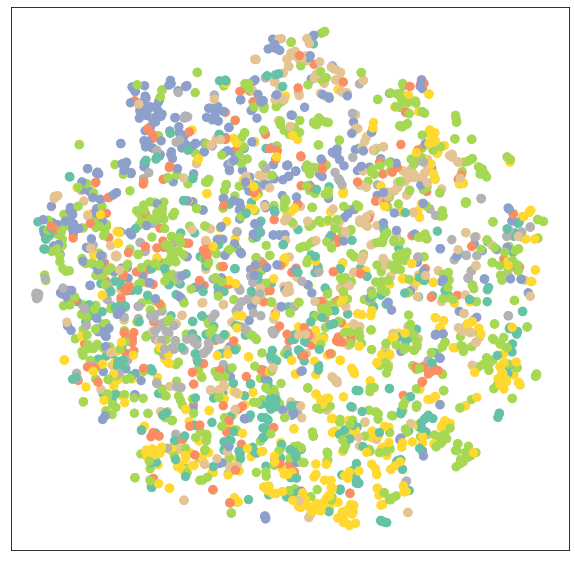

In [12]:
GCN_Model = GCN_2l(model_level='node', dim_node=1433, dim_hidden=100, num_classes=7)
print(GCN_Model)
#GCN_Model = GCN(16)
GCN_Model.eval()

out = GCN_Model(dataset_PGMExplainer.x, dataset_PGMExplainer.edge_index)
visualize(out, color=data.y)


In [13]:
GCN_Model_Optimizer = torch.optim.Adam(GCN_Model.parameters(), lr=0.01, weight_decay=5e-4)

In [14]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch


In [15]:
def loading_model(load_index):
  GCN_Model = GCN_2l(model_level='node', dim_node=1433, dim_hidden=100, num_classes=7)
  GCN_Model_Optimizer = torch.optim.Adam(params = GCN_Model.parameters(), lr=0.01)
  checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/model_classifier"+str(load_index)+".pt")
  GCN_Model.load_state_dict(checkpoint['model_state_dict'])
  GCN_Model.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return GCN_Model, GCN_Model_Optimizer, epoch

In [16]:
def visualize_losses(gcn_losses, epoch_history):
  gcn_losses_list = torch.stack(gcn_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("`GCN Model Loss in Epoch: " + str(epoch_history))
  ax.plot(gcn_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  

# **Traning Configurations**

In [17]:
def train_step():
  GCN_Model.train(True)

  GCN_Model_Optimizer.zero_grad()  
  GCN_Model_out = GCN_Model(dataset_PGMExplainer.x, dataset_PGMExplainer.edge_index)  

  GCN_Model_loss = loss_calculations(GCN_Model_out[dataset_PGMExplainer.train_mask], dataset_PGMExplainer.y[dataset_PGMExplainer.train_mask])  
  GCN_Model_loss.backward(retain_graph=True)

  GCN_Model_Optimizer.step()    


  return GCN_Model_loss


In [18]:
LOSS_Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [19]:
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


def train(EPOCHS, load_index):
  GCN_Model_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    GCN_Model_training_loss= train_step()
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GCN_Model_training_loss:.4f}')

    GCN_Model_training_loss_per_epoch.append(GCN_Model_training_loss)

    #break

    if (epoch + load_index + 1) % LOSS_Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(GCN_Model_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GCN_Model.state_dict(), 'optimizer_state_dict': GCN_Model_Optimizer.state_dict(), 'loss': GCN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier" + str(epoch + load_index + 1)+".pt")

  
  #return model_loss




Epoch: 001, PGMExplainer Model Loss: 1.9570
Epoch: 002, PGMExplainer Model Loss: 1.9409
Epoch: 003, PGMExplainer Model Loss: 1.9157
Epoch: 004, PGMExplainer Model Loss: 1.8808
Epoch: 005, PGMExplainer Model Loss: 1.8420
Epoch: 006, PGMExplainer Model Loss: 1.8173
Epoch: 007, PGMExplainer Model Loss: 1.8231
Epoch: 008, PGMExplainer Model Loss: 1.8137
Epoch: 009, PGMExplainer Model Loss: 1.7909
Epoch: 010, PGMExplainer Model Loss: 1.7728
Epoch: 011, PGMExplainer Model Loss: 1.7605
Epoch: 012, PGMExplainer Model Loss: 1.7485
Epoch: 013, PGMExplainer Model Loss: 1.7325
Epoch: 014, PGMExplainer Model Loss: 1.7096
Epoch: 015, PGMExplainer Model Loss: 1.6791
Epoch: 016, PGMExplainer Model Loss: 1.6438
Epoch: 017, PGMExplainer Model Loss: 1.6078
Epoch: 018, PGMExplainer Model Loss: 1.5705
Epoch: 019, PGMExplainer Model Loss: 1.5276
Epoch: 020, PGMExplainer Model Loss: 1.4809
Epoch: 021, PGMExplainer Model Loss: 1.4339
Epoch: 022, PGMExplainer Model Loss: 1.3829
Epoch: 023, PGMExplainer Model L

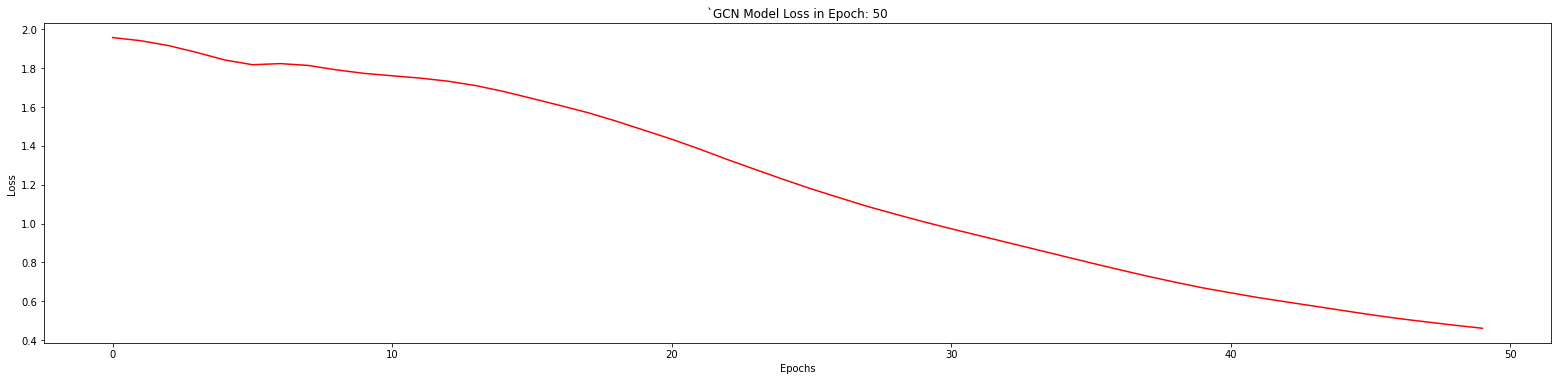

Epoch: 051, PGMExplainer Model Loss: 0.4462
Epoch: 052, PGMExplainer Model Loss: 0.4317
Epoch: 053, PGMExplainer Model Loss: 0.4169
Epoch: 054, PGMExplainer Model Loss: 0.4020
Epoch: 055, PGMExplainer Model Loss: 0.3889
Epoch: 056, PGMExplainer Model Loss: 0.3764
Epoch: 057, PGMExplainer Model Loss: 0.3624
Epoch: 058, PGMExplainer Model Loss: 0.3483
Epoch: 059, PGMExplainer Model Loss: 0.3355
Epoch: 060, PGMExplainer Model Loss: 0.3243
Epoch: 061, PGMExplainer Model Loss: 0.3137
Epoch: 062, PGMExplainer Model Loss: 0.3026
Epoch: 063, PGMExplainer Model Loss: 0.2918
Epoch: 064, PGMExplainer Model Loss: 0.2810
Epoch: 065, PGMExplainer Model Loss: 0.2714
Epoch: 066, PGMExplainer Model Loss: 0.2631
Epoch: 067, PGMExplainer Model Loss: 0.2559
Epoch: 068, PGMExplainer Model Loss: 0.2496
Epoch: 069, PGMExplainer Model Loss: 0.2427
Epoch: 070, PGMExplainer Model Loss: 0.2358
Epoch: 071, PGMExplainer Model Loss: 0.2290
Epoch: 072, PGMExplainer Model Loss: 0.2236
Epoch: 073, PGMExplainer Model L

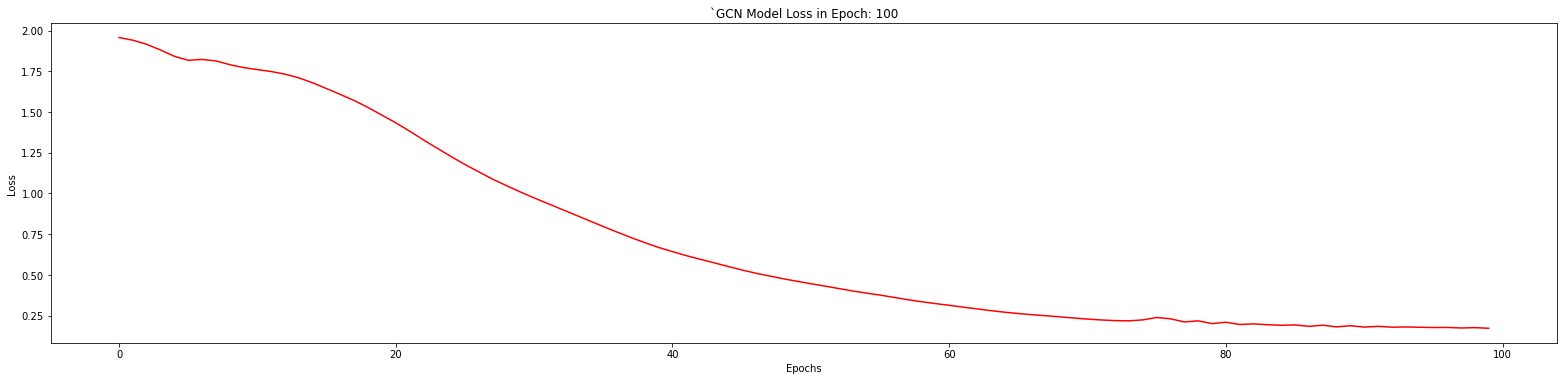

Epoch: 101, PGMExplainer Model Loss: 0.1741
Epoch: 102, PGMExplainer Model Loss: 0.1717
Epoch: 103, PGMExplainer Model Loss: 0.1717
Epoch: 104, PGMExplainer Model Loss: 0.1706
Epoch: 105, PGMExplainer Model Loss: 0.1694
Epoch: 106, PGMExplainer Model Loss: 0.1696
Epoch: 107, PGMExplainer Model Loss: 0.1675
Epoch: 108, PGMExplainer Model Loss: 0.1680
Epoch: 109, PGMExplainer Model Loss: 0.1665
Epoch: 110, PGMExplainer Model Loss: 0.1661
Epoch: 111, PGMExplainer Model Loss: 0.1656
Epoch: 112, PGMExplainer Model Loss: 0.1644
Epoch: 113, PGMExplainer Model Loss: 0.1645
Epoch: 114, PGMExplainer Model Loss: 0.1632
Epoch: 115, PGMExplainer Model Loss: 0.1629
Epoch: 116, PGMExplainer Model Loss: 0.1625
Epoch: 117, PGMExplainer Model Loss: 0.1613
Epoch: 118, PGMExplainer Model Loss: 0.1612
Epoch: 119, PGMExplainer Model Loss: 0.1604
Epoch: 120, PGMExplainer Model Loss: 0.1597
Epoch: 121, PGMExplainer Model Loss: 0.1595
Epoch: 122, PGMExplainer Model Loss: 0.1586
Epoch: 123, PGMExplainer Model L

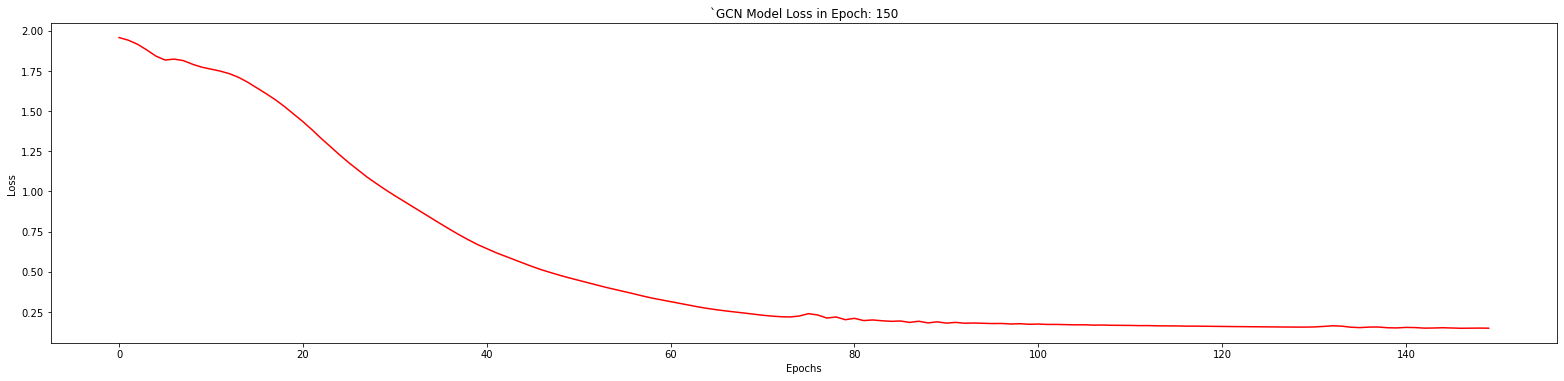

Epoch: 151, PGMExplainer Model Loss: 0.1474
Epoch: 152, PGMExplainer Model Loss: 0.1470
Epoch: 153, PGMExplainer Model Loss: 0.1470
Epoch: 154, PGMExplainer Model Loss: 0.1470
Epoch: 155, PGMExplainer Model Loss: 0.1465
Epoch: 156, PGMExplainer Model Loss: 0.1460
Epoch: 157, PGMExplainer Model Loss: 0.1455
Epoch: 158, PGMExplainer Model Loss: 0.1451
Epoch: 159, PGMExplainer Model Loss: 0.1452
Epoch: 160, PGMExplainer Model Loss: 0.1452
Epoch: 161, PGMExplainer Model Loss: 0.1448
Epoch: 162, PGMExplainer Model Loss: 0.1440
Epoch: 163, PGMExplainer Model Loss: 0.1435
Epoch: 164, PGMExplainer Model Loss: 0.1435
Epoch: 165, PGMExplainer Model Loss: 0.1434
Epoch: 166, PGMExplainer Model Loss: 0.1432
Epoch: 167, PGMExplainer Model Loss: 0.1429
Epoch: 168, PGMExplainer Model Loss: 0.1429
Epoch: 169, PGMExplainer Model Loss: 0.1429
Epoch: 170, PGMExplainer Model Loss: 0.1428
Epoch: 171, PGMExplainer Model Loss: 0.1425
Epoch: 172, PGMExplainer Model Loss: 0.1423
Epoch: 173, PGMExplainer Model L

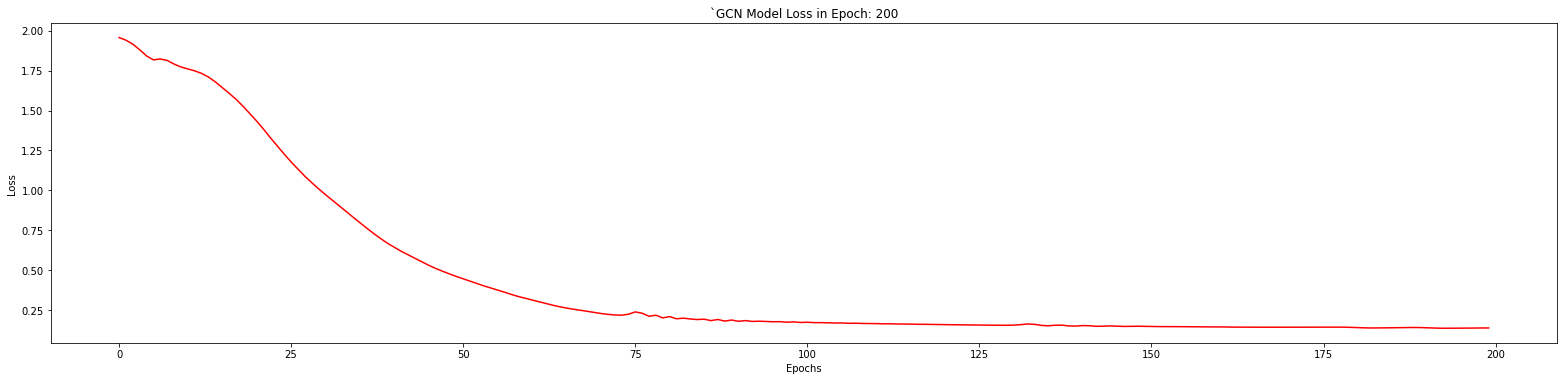

In [20]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  GCN_Model, GCN_Model_Optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [21]:
def GCN_Model_test():
  GCN_Model.eval()
  GCN_Model_out = GCN_Model(dataset_PGMExplainer.x, dataset_PGMExplainer.edge_index)
  GCN_Model_pred = GCN_Model_out.argmax(dim=1) 
  GCN_Model_test_correct = GCN_Model_pred[dataset_PGMExplainer.test_mask] == dataset_PGMExplainer.y[dataset_PGMExplainer.test_mask] 
  GCN_Model_test_acc = int(GCN_Model_test_correct.sum()) / int(dataset_PGMExplainer.test_mask.sum())
  return GCN_Model_test_acc

In [22]:
GCN_Model_test_acc = GCN_Model_test()
print(f'Test Accuracy: {GCN_Model_test_acc:.4f}')

Test Accuracy: 0.8800


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


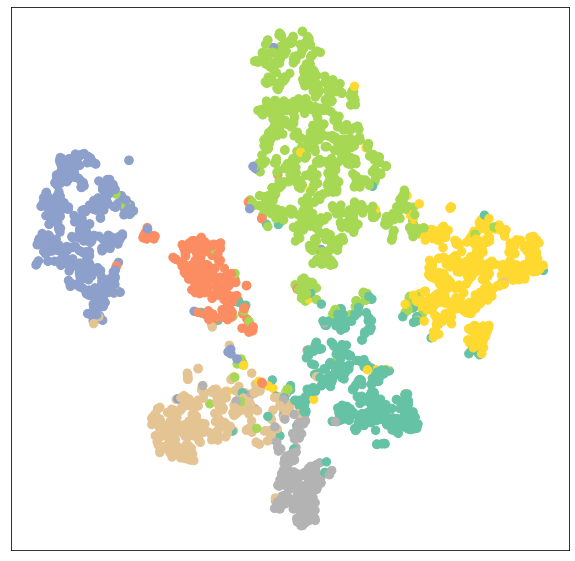

In [23]:
GCN_Model.eval()

GCN_Model_test_out = GCN_Model(dataset_PGMExplainer.x, dataset_PGMExplainer.edge_index)
visualize(GCN_Model_test_out, color = dataset_PGMExplainer.y)

# **Markov Blanket of T**

In [25]:
print(np.shape(dataset_PGMExplainer.x[dataset_PGMExplainer.train_mask]))
print(np.shape(dataset_PGMExplainer.x[dataset_PGMExplainer.test_mask]))
print(np.shape(dataset_PGMExplainer.x[dataset_PGMExplainer.val_mask]))

torch.Size([1891, 1433])
torch.Size([817, 1433])
torch.Size([500, 1433])


In [48]:
print(len(dataset_PGMExplainer.edge_index[1]))
#for i in range(100):
#  print(dataset_PGMExplainer.x[0][i])

10556


In [35]:
def markov_blanket_t(index):
  index = (One_Graph_Dataset.data.edge_index[0] == index).nonzero().view(-1)
  return index

In [38]:
print(markov_blanket_t(20))

tensor([64, 65, 66, 67, 68])


In [50]:
train_index_list = []
for i in range(len(dataset_PGMExplainer.train_mask)):
  if dataset_PGMExplainer.train_mask[i]:
    train_index_list.append(i)

In [63]:
how_many_nodes_to_pertube = 900
#print(np.random.normal(0.01, 0.001, 100))

In [64]:
perturbation_indication = []
for i in range(len(dataset_PGMExplainer.x)):
  perturbation_indication.append([0, 0])
for i in range(how_many_nodes_to_pertube):
  random_index = random.choice(train_index_list)
  perturbation_indication[random_index][0] = 1

# **Pertube dataset**

In [65]:
def pertube_data(list_p, dataset_pure):
  for i in range(len(list_p)):
    if list_p[i][0]:
      dataset_pure.x[i] = dataset_pure.x[i] + np.random.normal(0.01, 0.001, len(dataset_pure.x[i]))
  return dataset_pure

In [66]:
dataset_pertubed = pertube_data(perturbation_indication, dataset_PGMExplainer)